# Interpretability pipeline development

We sketch and explore here the design of a pipeline to capture and analyze xAI in NCO.

In [24]:
import os
from pathlib import Path
from typing import List

import pandas as pd
import numpy as np
import seaborn as sns
import joypy

import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients, DeepLift

import NegativeClassOptimization.config as config
import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.preprocessing as preprocessing
from NegativeClassOptimization import ml
from NegativeClassOptimization import datasets, pipelines

In [2]:
# TODO

# # Load from mlflow
# # Add ratios! of pos/neg
# # Add open set examples?

experiment_id = "11"
# run_name = "test"
run_id = "73a53fc4c0c74e7eababe4f1737cea0b"

# api = utils.MlflowAPI()
# r = api.mlflow_request(experiment_id, run_name)
# df = api.build_mlflow_results_df()
# df.head()

# # import requests

# # requests.get(
# #     "http://10.40.3.22:5000/api/2.0/mlflow/artifacts/list",
# #     json={
# #         "run_id": "73a53fc4c0c74e7eababe4f1737cea0b",
# #     },
# #     ).json()
# # # ftp_url = "ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/dataset/train_dataset.tsv/c35495f4_train_dataset.tsv"

# # # from urllib import request
# # # request.urlretrieve(ftp_url, filename=str("test.tsv"))

df_train_path = "../data/nco_mlflow_runs/ftp/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/dataset/train_dataset.tsv/c35495f4_train_dataset.tsv"
df_test_path = "../data/nco_mlflow_runs/ftp/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/dataset/test_dataset.tsv/c35495f4_test_dataset.tsv"
model_path = "../data/nco_mlflow_runs/ftp/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/models/trained_model"

1. Define and preprocess relevant pipeline inputs

In [10]:
df = utils.load_global_dataframe()
df_train = pd.read_csv(df_train_path, sep="\t")
df_test = pd.read_csv(df_test_path, sep="\t")
model = torch.load(Path(model_path) / "data/model.pth")
attributors = [
    ml.Attributor(model, type="integrated_gradients", baseline_type="zero", compute_on="logits"),
    ml.Attributor(model, type="integrated_gradients", baseline_type="shuffle", compute_on="logits"),
    ml.Attributor(model, type="deep_lift", baseline_type="zero", compute_on="logits"),
    ml.Attributor(model, type="deep_lift", baseline_type="shuffle", compute_on="logits"),
    # ml.Attributor(model, type="deep_lift", baseline_type="zero", compute_on="logits"),
    # ml.Attributor(model, type="deep_lift", baseline_type="shuffle", compute_on="logits"),
]

In [11]:
df_train.head()

,Slide,binds_a_pos_ag,Slide_farmhash_mod_32768,Slide_onehot,X,y
0,AAELFWYFDVW,1,3177,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
1,AAGYFFYFDVW,1,1605,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
2,AALLPIRPDGY,0,736,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
3,AASFGWDVGYF,0,2363,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
4,ADDYDLGVFPF,0,2068,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0


In [29]:
import warnings


N = 10
res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for row in df_train.sample(N).iterrows():
        slide = row[1]["Slide"]
        binds_a_pos_ag = row[1]["binds_a_pos_ag"]


        is_slide_in_train = slide in df_train["Slide"]
        enc = torch.tensor(preprocessing.onehot_encode(slide)).float().reshape((1, -1))
        expits, logits = model.forward(enc, return_logits=True)
        y_pred = expits.round()
        y_true = binds_a_pos_ag
        is_pred_correct = bool((y_pred == y_true)[0][0])
        # print(f"{y_pred=} ? {y_true=} => {is_pred_correct=}")


        res_attr = {}
        for attributor in attributors:
            attributions, baseline = attributor.attribute(enc, return_baseline=True)
            baseline_expits, baseline_logits = model.forward(baseline, return_logits=True)
            res_attr[attributor.name] = {
                "attributions": attributions,
                "baseline": baseline,
                "baseline_logits": baseline_logits,
                "baseline_expits": baseline_expits,
            }

        res[slide] = {
            "enc": enc,
            "logits": logits,
            "expits": expits,
            "y_pred": y_pred,
            "y_true": y_true,
            "is_pred_correct": is_pred_correct,
            "attributions": res_attr,
        }

In [39]:
df = pd.DataFrame.from_dict(res, orient="index")
df = df.sort_values("logits", ascending=False)
df.reset_index(inplace=True)
df.rename(columns={"index": "slide"}, inplace=True)

df["logits"] = df["logits"].astype(float)
df["expits"] = df["expits"].astype(float)
df["y_pred"] = df["y_pred"].astype(int)

df.head()

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions
0,AAELFWYFDVW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",8.903152,0.999864,1,1,True,{'integrated_gradients__logits__zero': {'attri...
1,AAGYFFYFDVW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",8.776468,0.999846,1,1,True,{'integrated_gradients__logits__zero': {'attri...
2,ADGYYFLFAYW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",7.852919,0.999612,1,1,True,{'integrated_gradients__logits__zero': {'attri...
3,AFDGYLFFDYW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",6.715902,0.998790,1,1,True,{'integrated_gradients__logits__zero': {'attri...
4,AEGMGLLLDYW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",3.889211,0.979949,1,1,True,{'integrated_gradients__logits__zero': {'attri...


In [50]:
# Create df_sel per attributor
attributor_sel = attributors[-1].name

records = []
for row in df.iterrows():
    s = row[1]
    attr_data = s["attributions"][attributor_sel]
    new_row_dict = {
        **dict(s),
        **attr_data,
    }
    records.append(new_row_dict)

df_sel = pd.DataFrame.from_records(records)
df_sel["baseline_logits"] = df_sel["baseline_logits"].astype(float)
df_sel["baseline_expits"] = df_sel["baseline_expits"].astype(float)
df_sel.head()

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,baseline_logits,baseline_expits
0,AAELFWYFDVW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",8.903152,0.999864,1,1,True,"[[tensor(-1.0450, grad_fn=<UnbindBackward0>), ...","[[tensor(0.2000), tensor(0.), tensor(0.0790), ...",-4.396590,0.012169
1,AAGYFFYFDVW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",8.776468,0.999846,1,1,True,"[[tensor(-1.1127, grad_fn=<UnbindBackward0>), ...","[[tensor(0.1810), tensor(0.), tensor(0.1180), ...",-4.414219,0.011959
2,ADGYYFLFAYW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",7.852919,0.999612,1,1,True,"[[tensor(-0.9758, grad_fn=<UnbindBackward0>), ...","[[tensor(0.1510), tensor(0.), tensor(0.1020), ...",-4.739618,0.008666
3,AFDGYLFFDYW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",6.715902,0.998790,1,1,True,"[[tensor(-0.6913, grad_fn=<UnbindBackward0>), ...","[[tensor(0.0850), tensor(0.), tensor(0.1800), ...",-4.327089,0.013034
4,AEGMGLLLDYW,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0...",3.889211,0.979949,1,1,True,"[[tensor(-1.4912, grad_fn=<UnbindBackward0>), ...","[[tensor(0.0930), tensor(0.), tensor(0.0840), ...",-4.690434,0.009099


In [60]:
# Plot
df_attr = pd.DataFrame(np.concatenate(df_sel["attributions"].map(lambda x: x.detach().numpy()), axis=0))
df_attr

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,-1.045016,0.0,0.501965,0.323429,-0.654910,-0.000000,-0.0,0.000000,-0.0,-0.169911,...,0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,-0.0,-0.066003,-0.233285,0.112658
1,-1.112731,0.0,0.797431,-0.000000,-1.026469,0.280164,-0.0,0.000000,-0.0,0.000000,...,0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,-0.0,-0.105633,-0.292064,0.262744
2,-0.975819,0.0,0.642033,-0.000000,-0.699078,0.249676,-0.0,0.000000,-0.0,-0.152409,...,0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,-0.0,0.000000,-0.200082,0.352415
3,-0.691317,0.0,0.942716,-0.000000,-0.801664,0.233125,-0.0,0.000000,-0.0,-0.087603,...,0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,-0.0,0.000000,-0.128048,0.209967
4,-1.491237,-0.0,0.420721,0.405301,0.000000,0.538379,-0.0,0.000000,-0.0,-0.788973,...,0.020162,-0.000000,-0.000000,0.0,-0.000000,-0.000000,-0.0,0.000000,-0.528105,0.137918
5,-1.629961,-0.0,0.905605,-0.000000,-0.143448,0.267347,-0.0,0.000000,-0.0,-0.291840,...,-0.000000,-0.000000,-0.000000,0.0,-0.000000,-0.000000,-0.0,-0.027228,-0.714522,0.121530
6,-1.570386,-0.0,0.399832,-0.000000,-0.520576,0.728511,-0.0,0.000000,-0.0,0.000000,...,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,0.277258,-0.0,0.043386,0.052456,0.118788
7,-1.419024,-0.0,0.252301,-0.000000,0.000000,0.226021,-0.0,-0.081532,-0.0,-0.554268,...,-0.000000,-0.000000,0.172158,0.0,0.087537,-0.000000,-0.0,-0.000000,-0.000000,-1.460037
8,-1.608557,-0.0,0.857948,-0.000000,-0.204263,0.233150,-0.0,0.000000,-0.0,-0.226338,...,-0.000000,-0.000000,0.091783,0.0,-0.000000,-0.000000,-0.0,-0.063570,-0.000000,0.154236
9,-1.236063,-0.0,-0.000000,0.312015,-0.119044,0.242066,-0.0,0.000000,-0.0,-0.246141,...,-0.000000,0.192737,-0.000000,0.0,-0.000000,-0.000000,-0.0,0.000000,0.104234,-1.379110


In [66]:
df_attr_m = df_attr.reset_index().melt(id_vars="index")
df_attr_m

,index,variable,value
0,0,0,-1.045016
1,1,0,-1.112731
2,2,0,-0.975819
3,3,0,-0.691317
4,4,0,-1.491237
...,...,...,...
2195,5,219,0.121530
2196,6,219,0.118788
2197,7,219,-1.460037
2198,8,219,0.154236


<AxesSubplot: >

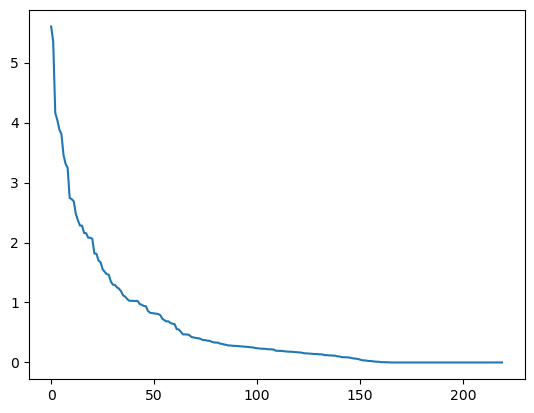

In [84]:
df_attr_range = df_attr_m.groupby("variable")["value"].agg(["max", "min"])
df_attr_range["range"] = df_attr_range["max"] - df_attr_range["min"]
df_attr_range.sort_values("range", ascending=False, inplace=True)
df_attr_range.reset_index()["range"].plot()

In [91]:
TH = 2
index_sel = df_attr_range.loc[df_attr_range["range"] >= TH].index.to_list()
df_attr_m["range_level"] = np.where(df_attr_m["variable"].isin(index_sel), "high", "low")

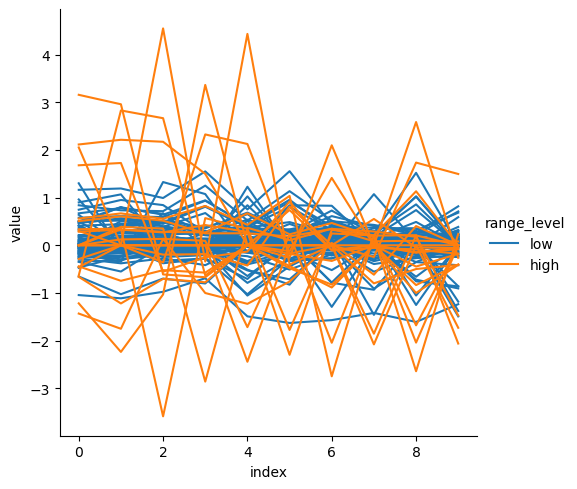

In [92]:
sns.relplot(
    data=df_attr_m,
    kind="line",
    x="index",
    y="value",
    units="variable",
    hue="range_level",
    estimator=None,
)

In [98]:
high_range_pos_mask = np.zeros((1, 220))
high_range_pos_mask[0, index_sel] = 1
high_range_pos_mask = high_range_pos_mask.reshape((11, 20))
high_range_pos_mask

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.

In [110]:
enc_ex = df_sel["enc"].iloc[0].detach().numpy().reshape((11, 20))
attr_ex = df_sel["attributions"].iloc[0].detach().numpy().reshape((11, 20))
print(df_sel["slide"].iloc[0])
attr_ex * high_range_pos_mask #* enc_ex

AAELFWYFDVW


array([[-0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        ,  0.        , -0.        , -0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ,  0.        ],
       [-0.        ,  0.        ,  0.33562717,  0.29829779, -0.        ,
        -0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.        , -0.        ],
       [-0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.        ,  0.        , -0.        ],
       [ 0.        , -0.        ,  0.        ,  0.        , -0.4422335 ,
        -0.        , -0.        ,  0.        , -